In [28]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [30]:
import numpy as np
import scipy.io as sio
import netCDF4 as nc
import glob, os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] =1e20
import cmocean
import xarray as xr
from xgcm import Grid
from gsw import sigma0, rho

In [31]:
%cd /work/eay/MITgcm_data/Experiment33/
#depth = xr.open_dataset('grid.nc')['Depth']

file0 = nc.Dataset('Temp13.nc')  #13 and index 3 for the 1.35 day results
file1 = nc.Dataset('Salt13.nc')
file2 = nc.Dataset('U13.nc')
file3 = nc.Dataset('V13.nc')
file4 = nc.Dataset('Eta13.nc')
NX = 4000
NY = 4000
NZ = 250

xq = (file1.variables['X'][:])
yq = (file1.variables['Y'][:])
zl = (file1.variables['Z'][:])
Time = file1.variables['T'][:]
print(Time.shape)

# xqmat=np.tile(xq,(NY,1))
# yqmat=np.tile(yq,(NX,1))
# yqmat=np.transpose(yqmat)
# print(yqmat.shape)
# print(xqmat.shape)

%cd /work/eay/MITgcm_data/

/work2/eay/MITgcm_data/Experiment33
(5,)
/work2/eay/MITgcm_data


In [32]:
Time[3]/86400

1.3541666666666667

In [33]:
#Reading in salinity
index = 3
mask = file1.variables['S'][0,0,:,:]
mask.shape
Salt = file1.variables['S'][index,0,:,:]
Salt[mask==0]=np.nan

In [34]:
#Computing freshwater layer
newmask = file1.variables['S'][0,:,:,:]


Salt_h = file1.variables['S'][index,:,:,:]; Salt_h[newmask==0]=np.nan
hf=0.1*np.nansum((34-Salt_h)/34.0,axis=0)
hf[(mask==0)]=np.nan


In [35]:
import sys
import numpy as np

__doc__ = """
Density of Sea Water using McDougall et al. 2003 (JAOT 20) polynomial
"""
# coefficients nonlinear equation of state in pressure coordinates for
eosMDJWFnum =  [ 7.35212840e+00,
                -5.45928211e-02,
                 3.98476704e-04,
                 2.96938239e+00,
                -7.23268813e-03,
                 2.12382341e-03,
                 1.04004591e-02,
                 1.03970529e-07,
                 5.18761880e-06,
                -3.24041825e-08,
                -1.23869360e-11,
                 9.99843699e+02 ]
eosMDJWFden =  [ 7.28606739e-03,
                -4.60835542e-05,
                 3.68390573e-07,
                 1.80809186e-10,
                 2.14691708e-03,
                -9.27062484e-06,
                -1.78343643e-10,
                 4.76534122e-06,
                 1.63410736e-09,
                 5.30848875e-06,
                -3.03175128e-16,
                -1.27934137e-17,
                 1.00000000e+00 ]
def densmdjwf(s,theta,p):
    """
    Computes in-situ density of sea water
    Density of Sea Water using McDougall et al. 2003 (JAOT 20)
    polynomial (Gibbs Potential).

    Parameters
    ----------
    s : array_like
        salinity [psu (PSS-78)]
    theta : array_like
        potential temperature [degree C (IPTS-68)];
        same shape as s
    p : array_like
        pressure [dbar]; broadcastable to shape of s

    Returns
    -------
    dens : array
        density [kg/m^3]

    Example
    -------
    >>> densmdjwf(35., 25., 2000.)
    1031.654229

    Notes
    -----
    AUTHOR:  Martin Losch 2002-08-09  (Martin.Losch@awi.de)

    McDougall et al., 2003, JAOT 20(5), pp. 730-741
    """
    
    # make sure arguments are floating point
    s = np.asfarray(s)
    t = np.asfarray(theta)
    p = np.asfarray(p)

    p1 = np.copy(p);
    
    t1 = np.copy(t);
    t2 = t*t;
    
    s1 = np.copy(s);
    if np.any(s1<0):
        sys.stderr.write('negative salinity values! setting to nan\n')
        # # the sqrt will take care of this
        # if s.ndim > 0:
        #     s[s<0] = np.nan
        # else:
        #     s = np.nan
    sp5 = np.sqrt(s1)
    p1t1=p1*t1
    num = ( eosMDJWFnum[11] 
            + t1*(eosMDJWFnum[0]
                  + t1*(eosMDJWFnum[1] + eosMDJWFnum[2]*t1) )
            + s1*(eosMDJWFnum[3]
                  + eosMDJWFnum[4]*t1  + eosMDJWFnum[5]*s1)
            + p1*(eosMDJWFnum[6] + eosMDJWFnum[7]*t2
                  + eosMDJWFnum[8]*s1
                  + p1*(eosMDJWFnum[9] + eosMDJWFnum[10]*t2) )
    )
    den = ( eosMDJWFden[12]
            + t1*(eosMDJWFden[0]
                  + t1*(eosMDJWFden[1]
                        + t1*(eosMDJWFden[2] + t1*eosMDJWFden[3] ) ) )
            + s1*(eosMDJWFden[4]
                  + t1*(eosMDJWFden[5]
                        + eosMDJWFden[6]*t2)
                  + sp5*(eosMDJWFden[7] + eosMDJWFden[8]*t2) )
            + p1*(eosMDJWFden[9]
                  + p1t1*(eosMDJWFden[10]*t2 + eosMDJWFden[11]*p1) )
    )
    epsln = 0
    denom = 1.0/(epsln+den)
    rho = num*denom;

    return rho
# aliases
dens = densmdjwf

In [36]:
print(densmdjwf(34., 15., 0.),'MDJWF @ 34psu, 15C')

1025.2031586387247 MDJWF @ 34psu, 15C


In [37]:
#Computing inverse Froude number

mask3D = file1.variables['S'][0,:,:,:]
Temp = file0.variables['Temp'][index,:,:,:]; Temp[mask3D==0]=np.nan
Salt_fr = file1.variables['S'][index,:,:,:]; Salt_fr[mask3D==0]=np.nan
hf_fr=0.1*np.nansum((34-Salt_fr)/34.0,axis=0)
hf_fr[(mask==0)]=np.nan

drho= densmdjwf(34.,15.,0)-densmdjwf(0.,15.,0);
rho_o=densmdjwf(34.,15.,0);
C_int=np.sqrt(9.81*drho*hf_fr/rho_o)


U = (file2.variables['U'][index,0,:,1:]+file2.variables['U'][index,0,:,:-1])/2
V = (file3.variables['V'][index,0,1:,:]+file3.variables['V'][index,0,:-1,:])/2

velocity = np.sqrt(U**2+V**2) 
velocity[(mask==0)]=np.nan

Fr = velocity/C_int; 
Inv_Fr=C_int/velocity

print('done')

done


### Computing Ertel Potential Vorticity (using xarray)

In [38]:
%cd /work/eay/MITgcm_data/Experiment33/

#13 and index 3 for the 1.35 day results
#21 and index -1 for the 2.04 day results
fs= xr.open_dataset('U13.nc')
Temp_PV = xr.open_dataset('Temp13.nc')['Temp'][3,:]
Salt_PV = xr.open_dataset('Salt13.nc')['S'][3,:]
U_PV = xr.open_dataset('U13.nc')['U'][3,:]
V_PV = xr.open_dataset('V13.nc')['V'][3,:]
%cd /work/eay/MITgcm_data/

print('done with variables')


grid= Grid(fs, coords={'X': {'center': 'X', 'outer': 'Xp1'}, #This tells the grid where xh, xq, yh, and yq are defined.
                       'Y': {'center': 'Y', 'outer': 'Yp1'}});

U_PV = grid.interp(U_PV[:],axis='X')#.fillna(0.); 
V_PV = grid.interp(V_PV[:],axis='Y')#.fillna(0.); 

Density = rho(Salt_PV[0:11,:,:],Temp_PV[0:11,:,:],0)
g = 9.81
rho_o = 1025
f = 8.0e-5
drhodx = Density.differentiate('X')
dvdz = V_PV[0:11,:].differentiate('Z')
drhodz = Density.differentiate('Z')
dvdx = V_PV[0:11,:].differentiate('X')

EPV=(g/rho_o)*(drhodx*dvdz)-(g/rho_o)*drhodz*(dvdx+f)
EPV=EPV.where(Salt_PV[0:11,:]>0)
print('done')


/work2/eay/MITgcm_data/Experiment33
/work2/eay/MITgcm_data
done with variables
done


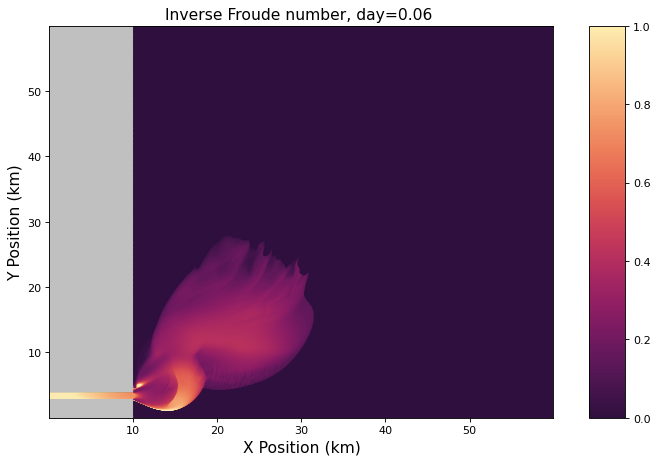

In [39]:
fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([.9, 0.1, 0.05, 0.7])

Inv_Fr[mask==0]=np.nan
current_cmap = plt.cm.get_cmap(cmocean.cm.matter_r).copy()
current_cmap.set_bad(color='silver')
quad1 = ax1.pcolormesh(xq/1000,yq/1000,Inv_Fr,cmap=current_cmap,shading='gouraud',vmin=0,vmax=1.)
#ax1.set_xlim(0,30)
ax1.set_title('Inverse Froude number, day=%04.2f ' %(index/48.), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('X Position (km)',fontsize=14)
ax1.set_ylabel('Y Position (km)',fontsize=14)
cb1 = fig.colorbar(quad1,ax2)

In [40]:
EPV.shape

(11, 4000, 4000)

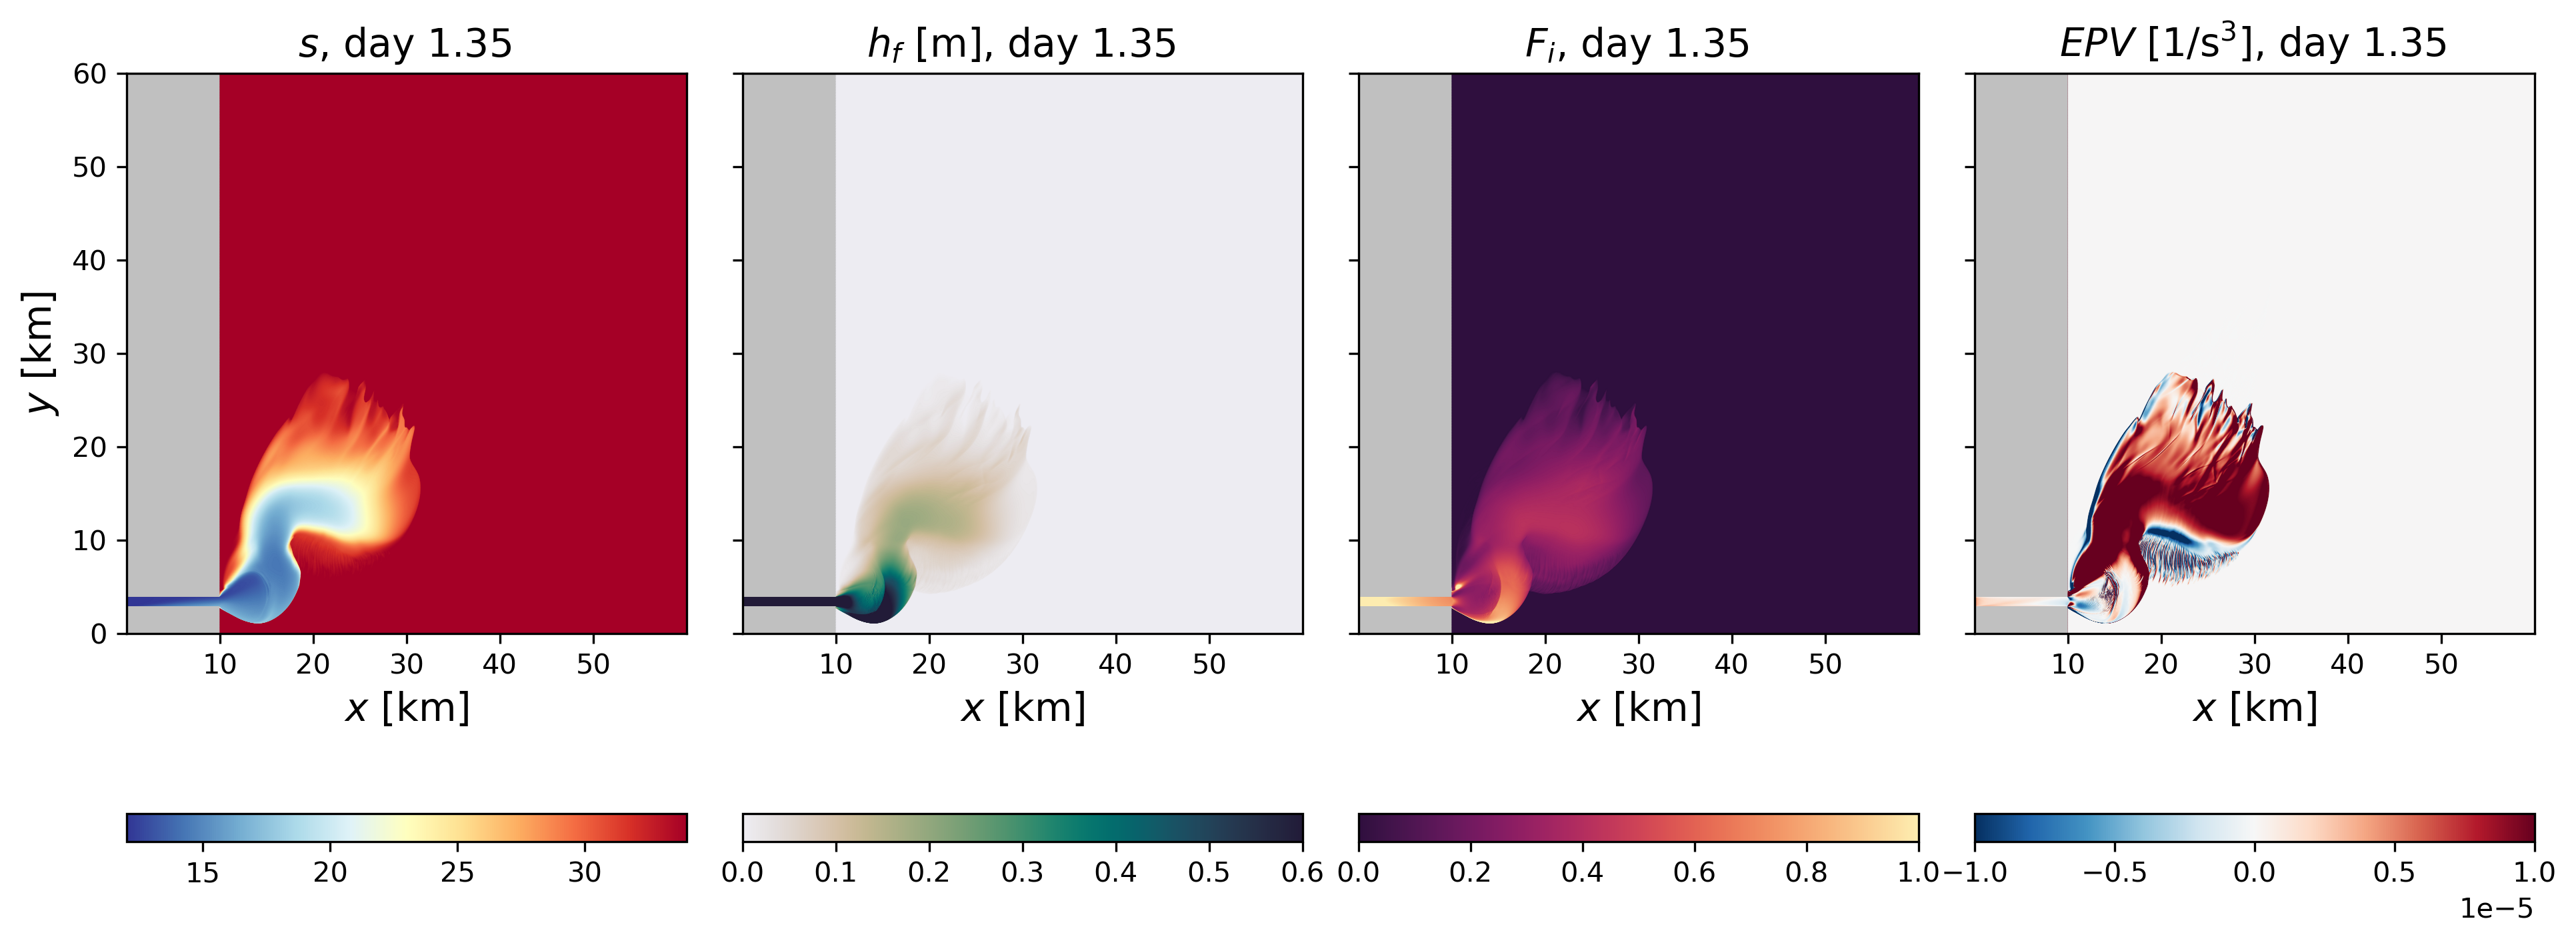

In [41]:
#For 1.35 Days use this cell

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(14, 10), dpi= 300, facecolor='w', edgecolor='k')
#main plots
ax1 = fig.add_axes([0.1,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.32,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax3 = fig.add_axes([0.54,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax4 = fig.add_axes([0.76,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)


#FIRST SUBPLOT
current_cmap = plt.cm.get_cmap("RdYlBu_r").copy()
current_cmap.set_bad(color='silver')
quad1 = ax1.pcolormesh(xq/1000,yq/1000,Salt,cmap=current_cmap,vmin=12.,vmax=34.,shading='gouraud')
ax1.set_title('$s$, day %04.2f ' %(1.35), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_ylabel('$y$ [km]',fontsize=14)
ax1.set_ylim([0,60]); 

ax1.set_aspect('equal'); #ax1.set_xlim([0, 30]); ax1.set_ylim([35,85])
divider1 = make_axes_locatable(ax1); cax1 = divider1.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax1); fig.colorbar(quad1, cax=cax1, orientation="horizontal")
#ax1.text(0.05, 0.9, '$a$', transform=ax1.transAxes,fontsize=25)

current_cmap = plt.cm.get_cmap(cmocean.cm.rain).copy()
current_cmap.set_bad(color='silver')
quad2 = ax2.pcolormesh(xq/1000,yq/1000,hf,cmap=current_cmap,shading='gouraud',vmin=0,vmax=.6)
ax2.set_title('$h_f$ [m], day %04.2f ' %(1.35), fontsize=14)
ax2.set_facecolor((0.92, 0.92, 0.92))
ax2.axes.set_yticklabels([])
ax2.set_xlabel('$x$ [km]',fontsize=14)
ax2.set_ylim([0,60]); 
ax2.set_aspect('equal'); #ax2.set_xlim([0, 30]); ax2.set_ylim([35,85])
divider2 = make_axes_locatable(ax2); cax2 = divider2.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax2); fig.colorbar(quad2, cax=cax2, orientation="horizontal")
#ax2.text(0.05, 0.9, '$b$',transform=ax2.transAxes,fontsize=25)


current_cmap = plt.cm.get_cmap(cmocean.cm.matter_r).copy()
current_cmap.set_bad(color='silver')
quad3 = ax3.pcolormesh(xq/1000,yq/1000,Inv_Fr,cmap=current_cmap,shading='gouraud',vmin=0,vmax=1.)
ax3.set_title('$F_i$, day %04.2f ' %(1.35), fontsize=14)
ax3.set_facecolor((0.92, 0.92, 0.92))
ax3.axes.set_yticklabels([])
ax3.set_xlabel('$x$ [km]',fontsize=14)
ax3.set_ylim([0,60]); 
ax3.set_aspect('equal'); #ax3.set_xlim([0, 30]); ax3.set_ylim([35,85])
divider3 = make_axes_locatable(ax3); cax3 = divider3.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax3); fig.colorbar(quad3, cax=cax3, orientation="horizontal")

current_cmap = plt.cm.get_cmap("RdBu_r").copy()
current_cmap.set_bad(color='silver')
quad4 = ax4.pcolormesh(xq/1000,yq/1000,EPV[0,:],cmap=current_cmap,shading='gouraud',vmin=-1e-5,vmax=1e-5)
ax4.set_title('$EPV$ [1/s$^3$], day %04.2f ' %(1.35), fontsize=14)
ax4.set_facecolor((0.92, 0.92, 0.92))
ax4.axes.set_yticklabels([])
ax4.set_xlabel('$x$ [km]',fontsize=14)
ax4.set_ylim([0,60]); 
ax4.set_aspect('equal'); #ax3.set_xlim([0, 30]); ax3.set_ylim([35,85])
divider4 = make_axes_locatable(ax4); cax4 = divider4.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax4); fig.colorbar(quad4, cax=cax4, orientation="horizontal")

plt.show()


#fig.savefig('Figure1.png', format='png', dpi=600)

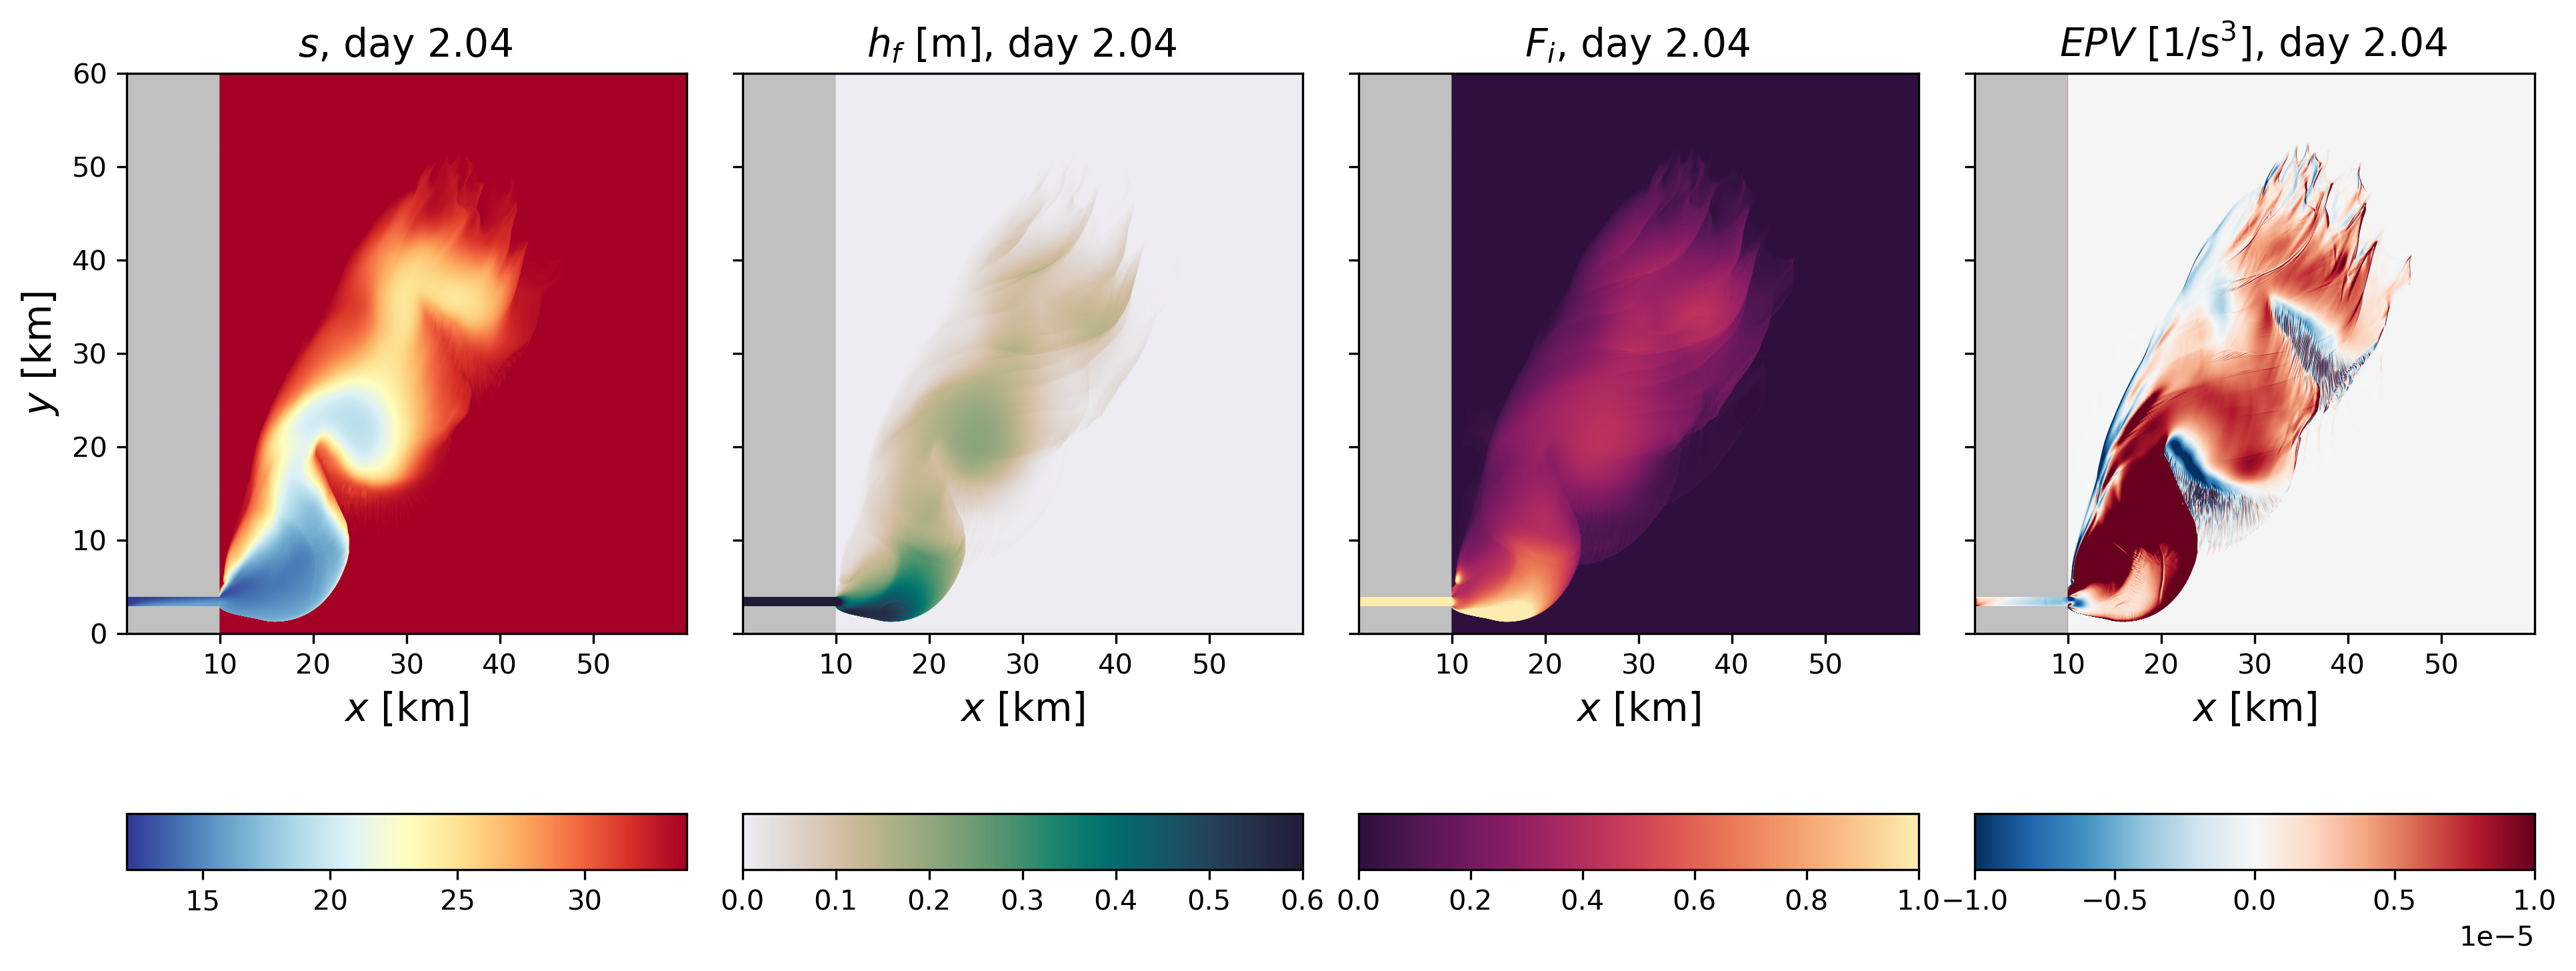

In [15]:
#For 2.04 days (end of simulation)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(14, 10), dpi= 300, facecolor='w', edgecolor='k')
#main plots
ax1 = fig.add_axes([0.1,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.32,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax3 = fig.add_axes([0.54,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax4 = fig.add_axes([0.76,0.2,0.2,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)


#FIRST SUBPLOT
current_cmap = plt.cm.get_cmap("RdYlBu_r").copy()
current_cmap.set_bad(color='silver')
quad1 = ax1.pcolormesh(xq/1000,yq/1000,Salt,cmap=current_cmap,vmin=12.,vmax=34.,shading='gouraud')
ax1.set_title('$s$, day %04.2f ' %(2.04), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_ylabel('$y$ [km]',fontsize=14)
ax1.set_ylim([0,60])

ax1.set_aspect('equal'); #ax1.set_xlim([0, 30]); ax1.set_ylim([35,85])
divider1 = make_axes_locatable(ax1); cax1 = divider1.new_vertical(size="10%", pad=0.9, pack_start=True)
fig.add_axes(cax1); fig.colorbar(quad1, cax=cax1, orientation="horizontal")
#ax1.text(0.05, 0.9, '$a$', transform=ax1.transAxes,fontsize=25)

current_cmap = plt.cm.get_cmap(cmocean.cm.rain).copy()
current_cmap.set_bad(color='silver')
quad2 = ax2.pcolormesh(xq/1000,yq/1000,hf,cmap=current_cmap,shading='gouraud',vmin=0,vmax=.6)
ax2.set_title('$h_f$ [m], day %04.2f ' %(2.04), fontsize=14)
ax2.set_facecolor((0.92, 0.92, 0.92))
ax2.axes.set_yticklabels([])
ax2.set_xlabel('$x$ [km]',fontsize=14)
ax2.set_ylim([0,60])

ax2.set_aspect('equal'); #ax2.set_xlim([0, 30]); ax2.set_ylim([35,85])
divider2 = make_axes_locatable(ax2); cax2 = divider2.new_vertical(size="10%", pad=0.9, pack_start=True)
fig.add_axes(cax2); fig.colorbar(quad2, cax=cax2, orientation="horizontal")
#ax2.text(0.05, 0.9, '$b$',transform=ax2.transAxes,fontsize=25)


current_cmap = plt.cm.get_cmap(cmocean.cm.matter_r).copy()
current_cmap.set_bad(color='silver')
quad3 = ax3.pcolormesh(xq/1000,yq/1000,Inv_Fr,cmap=current_cmap,shading='gouraud',vmin=0,vmax=1.)
ax3.set_title('$F_i$, day %04.2f ' %(2.04), fontsize=14)
ax3.set_facecolor((0.92, 0.92, 0.92))
ax3.axes.set_yticklabels([])
ax3.set_xlabel('$x$ [km]',fontsize=14)
ax3.set_ylim([0,60])

ax3.set_aspect('equal'); #ax3.set_xlim([0, 30]); ax3.set_ylim([35,85])
divider3 = make_axes_locatable(ax3); cax3 = divider3.new_vertical(size="10%", pad=0.9, pack_start=True)
fig.add_axes(cax3); fig.colorbar(quad3, cax=cax3, orientation="horizontal")

current_cmap = plt.cm.get_cmap("RdBu_r").copy()
current_cmap.set_bad(color='silver')
quad4 = ax4.pcolormesh(xq/1000,yq/1000,EPV[0,:],cmap=current_cmap,shading='gouraud',vmin=-1e-5,vmax=1e-5)
ax4.set_title('$EPV$ [1/s$^3$], day %04.2f ' %(2.04), fontsize=14)
ax4.set_facecolor((0.92, 0.92, 0.92))
ax4.axes.set_yticklabels([])
ax4.set_xlabel('$x$ [km]',fontsize=14)
ax4.set_ylim([0,60])

ax4.set_aspect('equal'); #ax3.set_xlim([0, 30]); ax3.set_ylim([35,85])
divider4 = make_axes_locatable(ax4); cax4 = divider4.new_vertical(size="10%", pad=0.9, pack_start=True)
fig.add_axes(cax4); fig.colorbar(quad4, cax=cax4, orientation="horizontal")

plt.show()